Column Names in Dataset: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (577) in plot_posterior, generating only 40 plots
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1154) in plot_autocorr, generating only 40 plots
  warnings.warn(


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]   -0.606  0.120  -0.832   -0.383      0.002    0.003    2753.0   
betas[1]   -1.121  0.157  -1.411   -0.828      0.003    0.003    2234.0   
betas[2]   -1.308  0.121  -1.528   -1.078      0.002    0.003    2508.0   
betas[3]   -0.552  0.136  -0.809   -0.295      0.003    0.003    2563.0   
betas[4]   -0.324  0.134  -0.577   -0.077      0.003    0.003    2355.0   
...           ...    ...     ...      ...        ...      ...       ...   
theta[564]  0.065  0.019   0.033    0.102      0.000    0.000    2667.0   
theta[565]  0.346  0.066   0.220    0.462      0.001    0.001    2981.0   
theta[566]  0.047  0.013   0.024    0.070      0.000    0.000    2181.0   
theta[567]  0.341  0.058   0.234    0.451      0.001    0.001    2518.0   
theta[568]  0.111  0.023   0.072    0.156      0.000    0.001    2466.0   

            ess_tail  r_hat  
betas[0]      1580.0   1.01  
betas[1]      1621.0   1.00  
betas[2] 

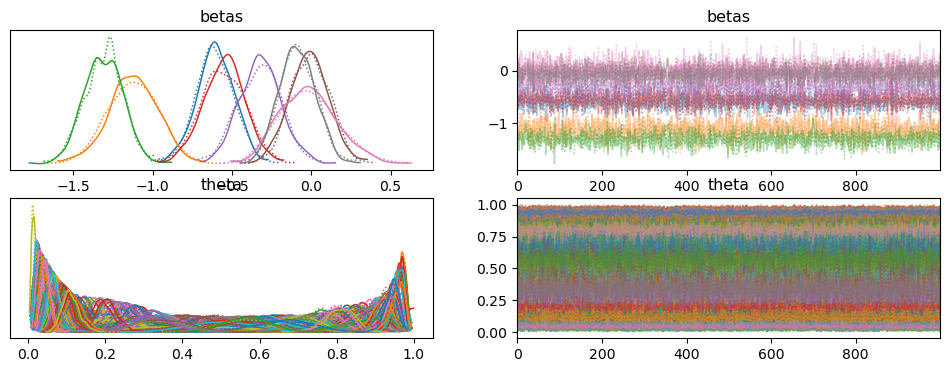

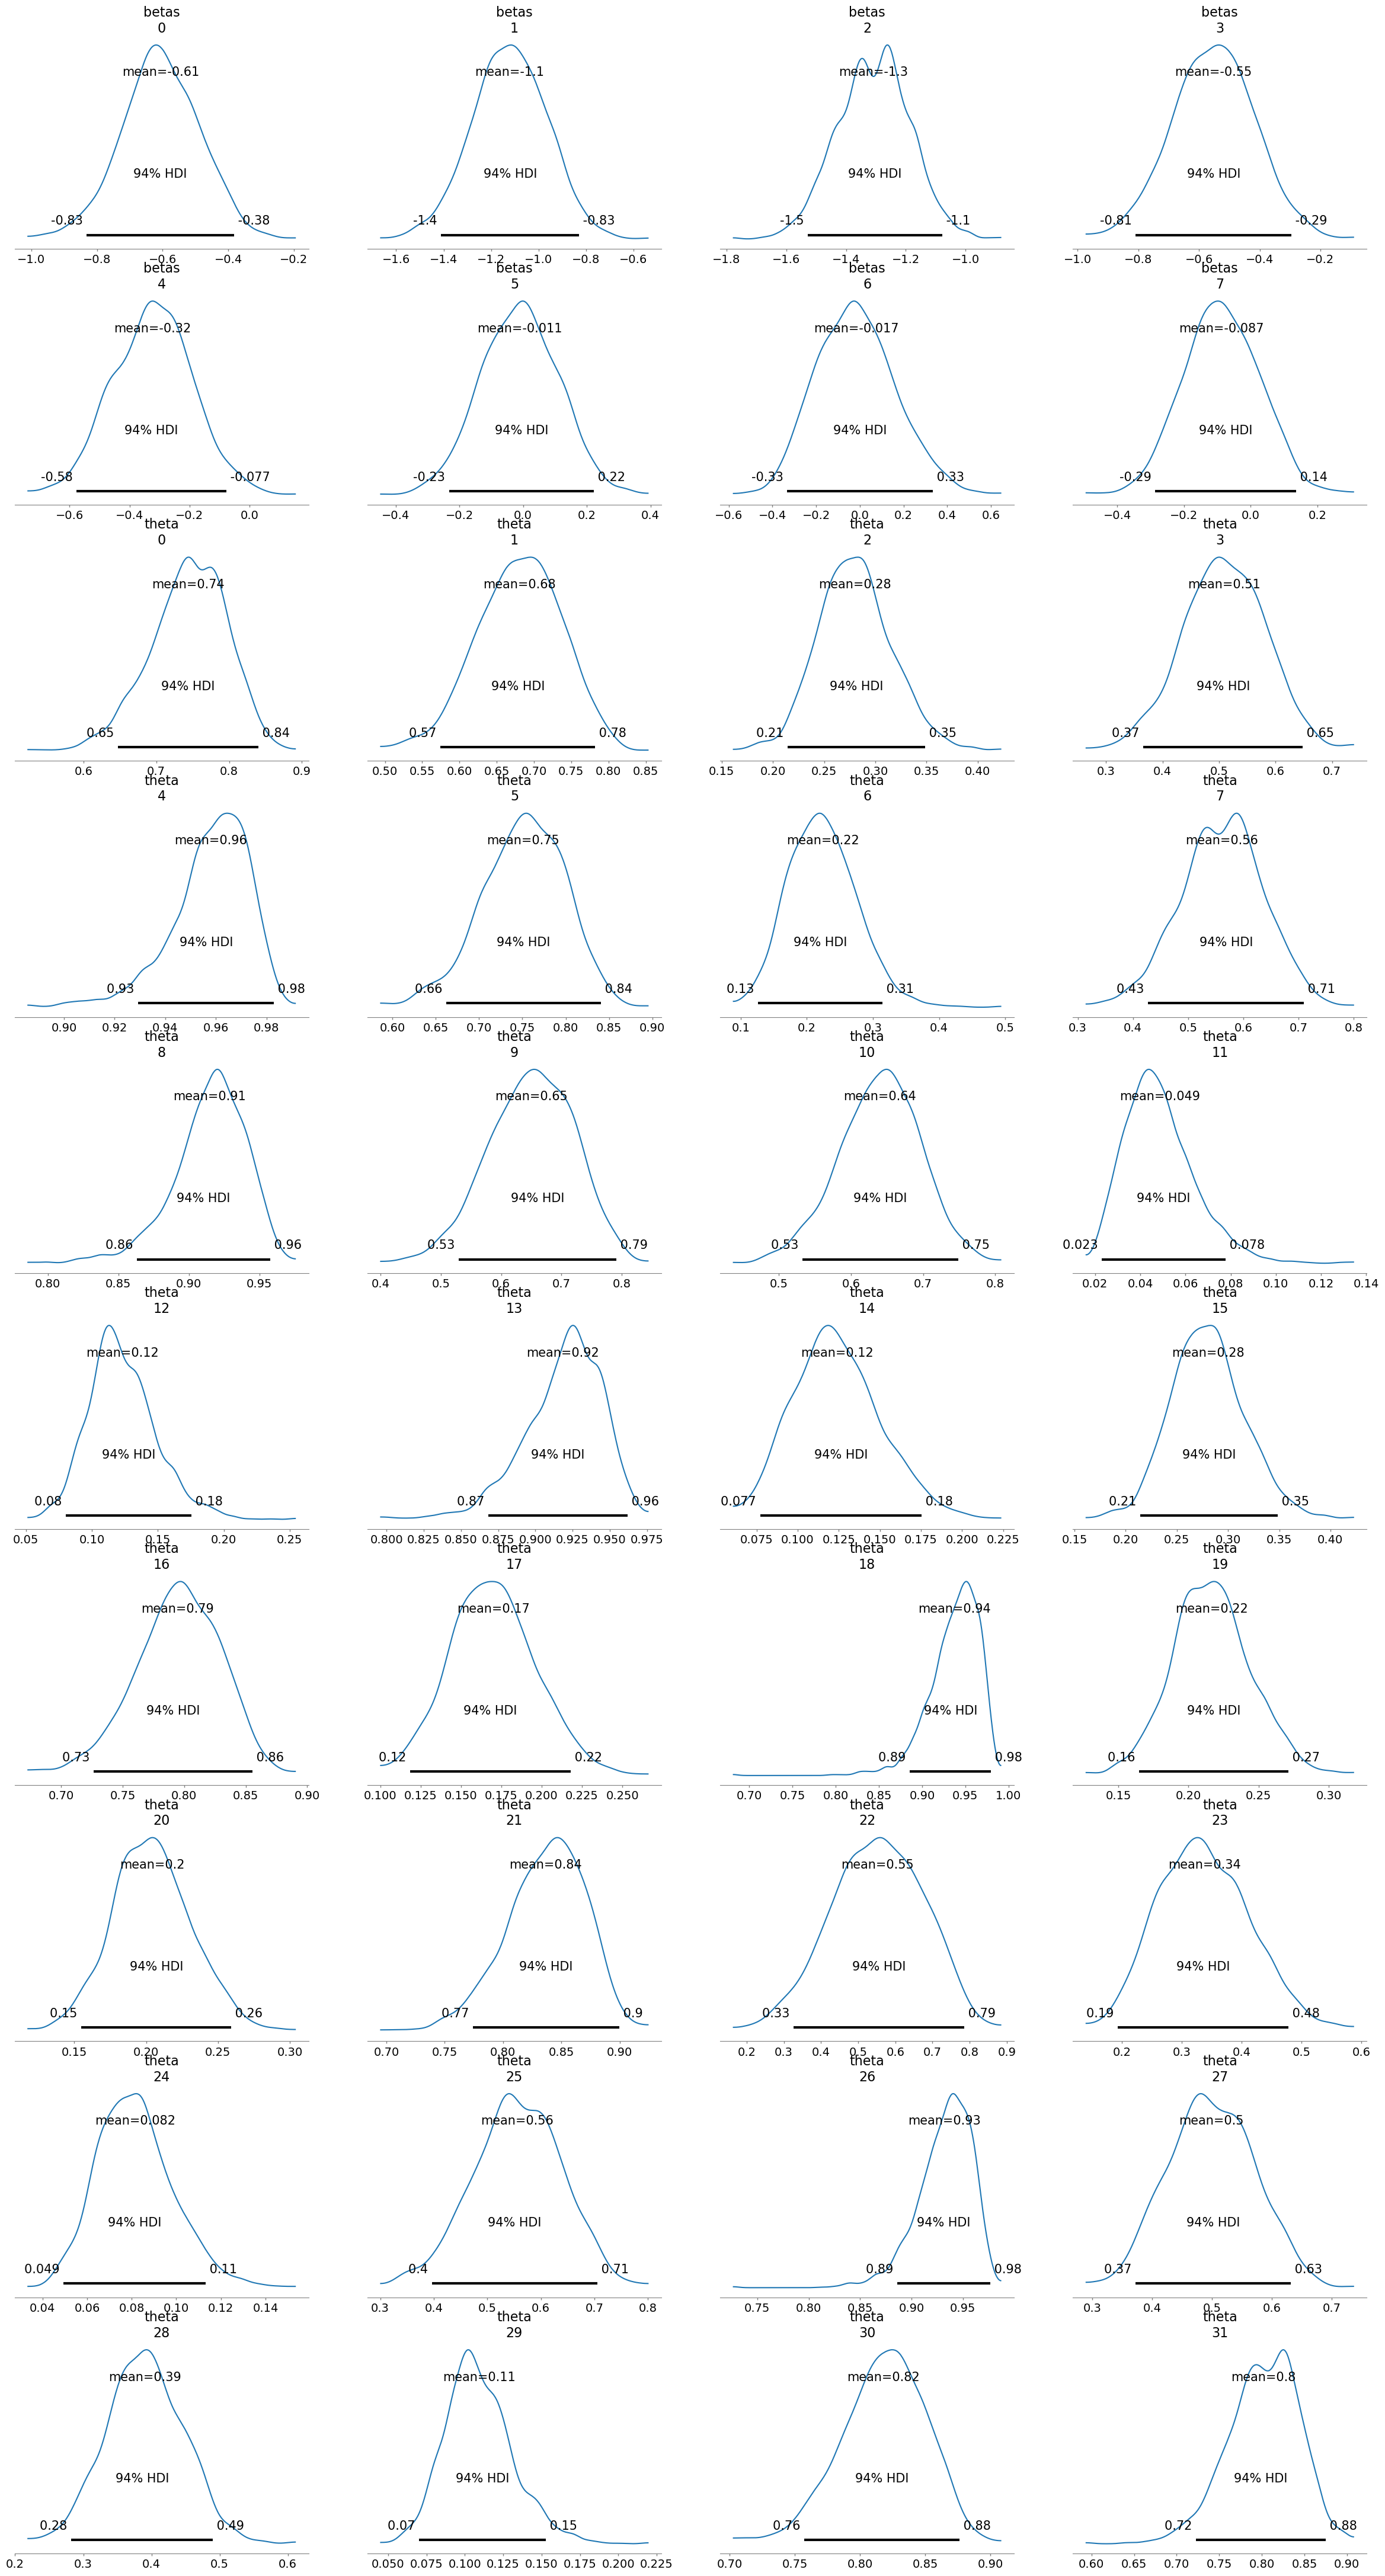

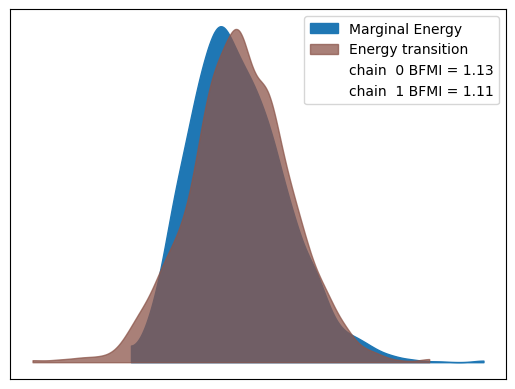

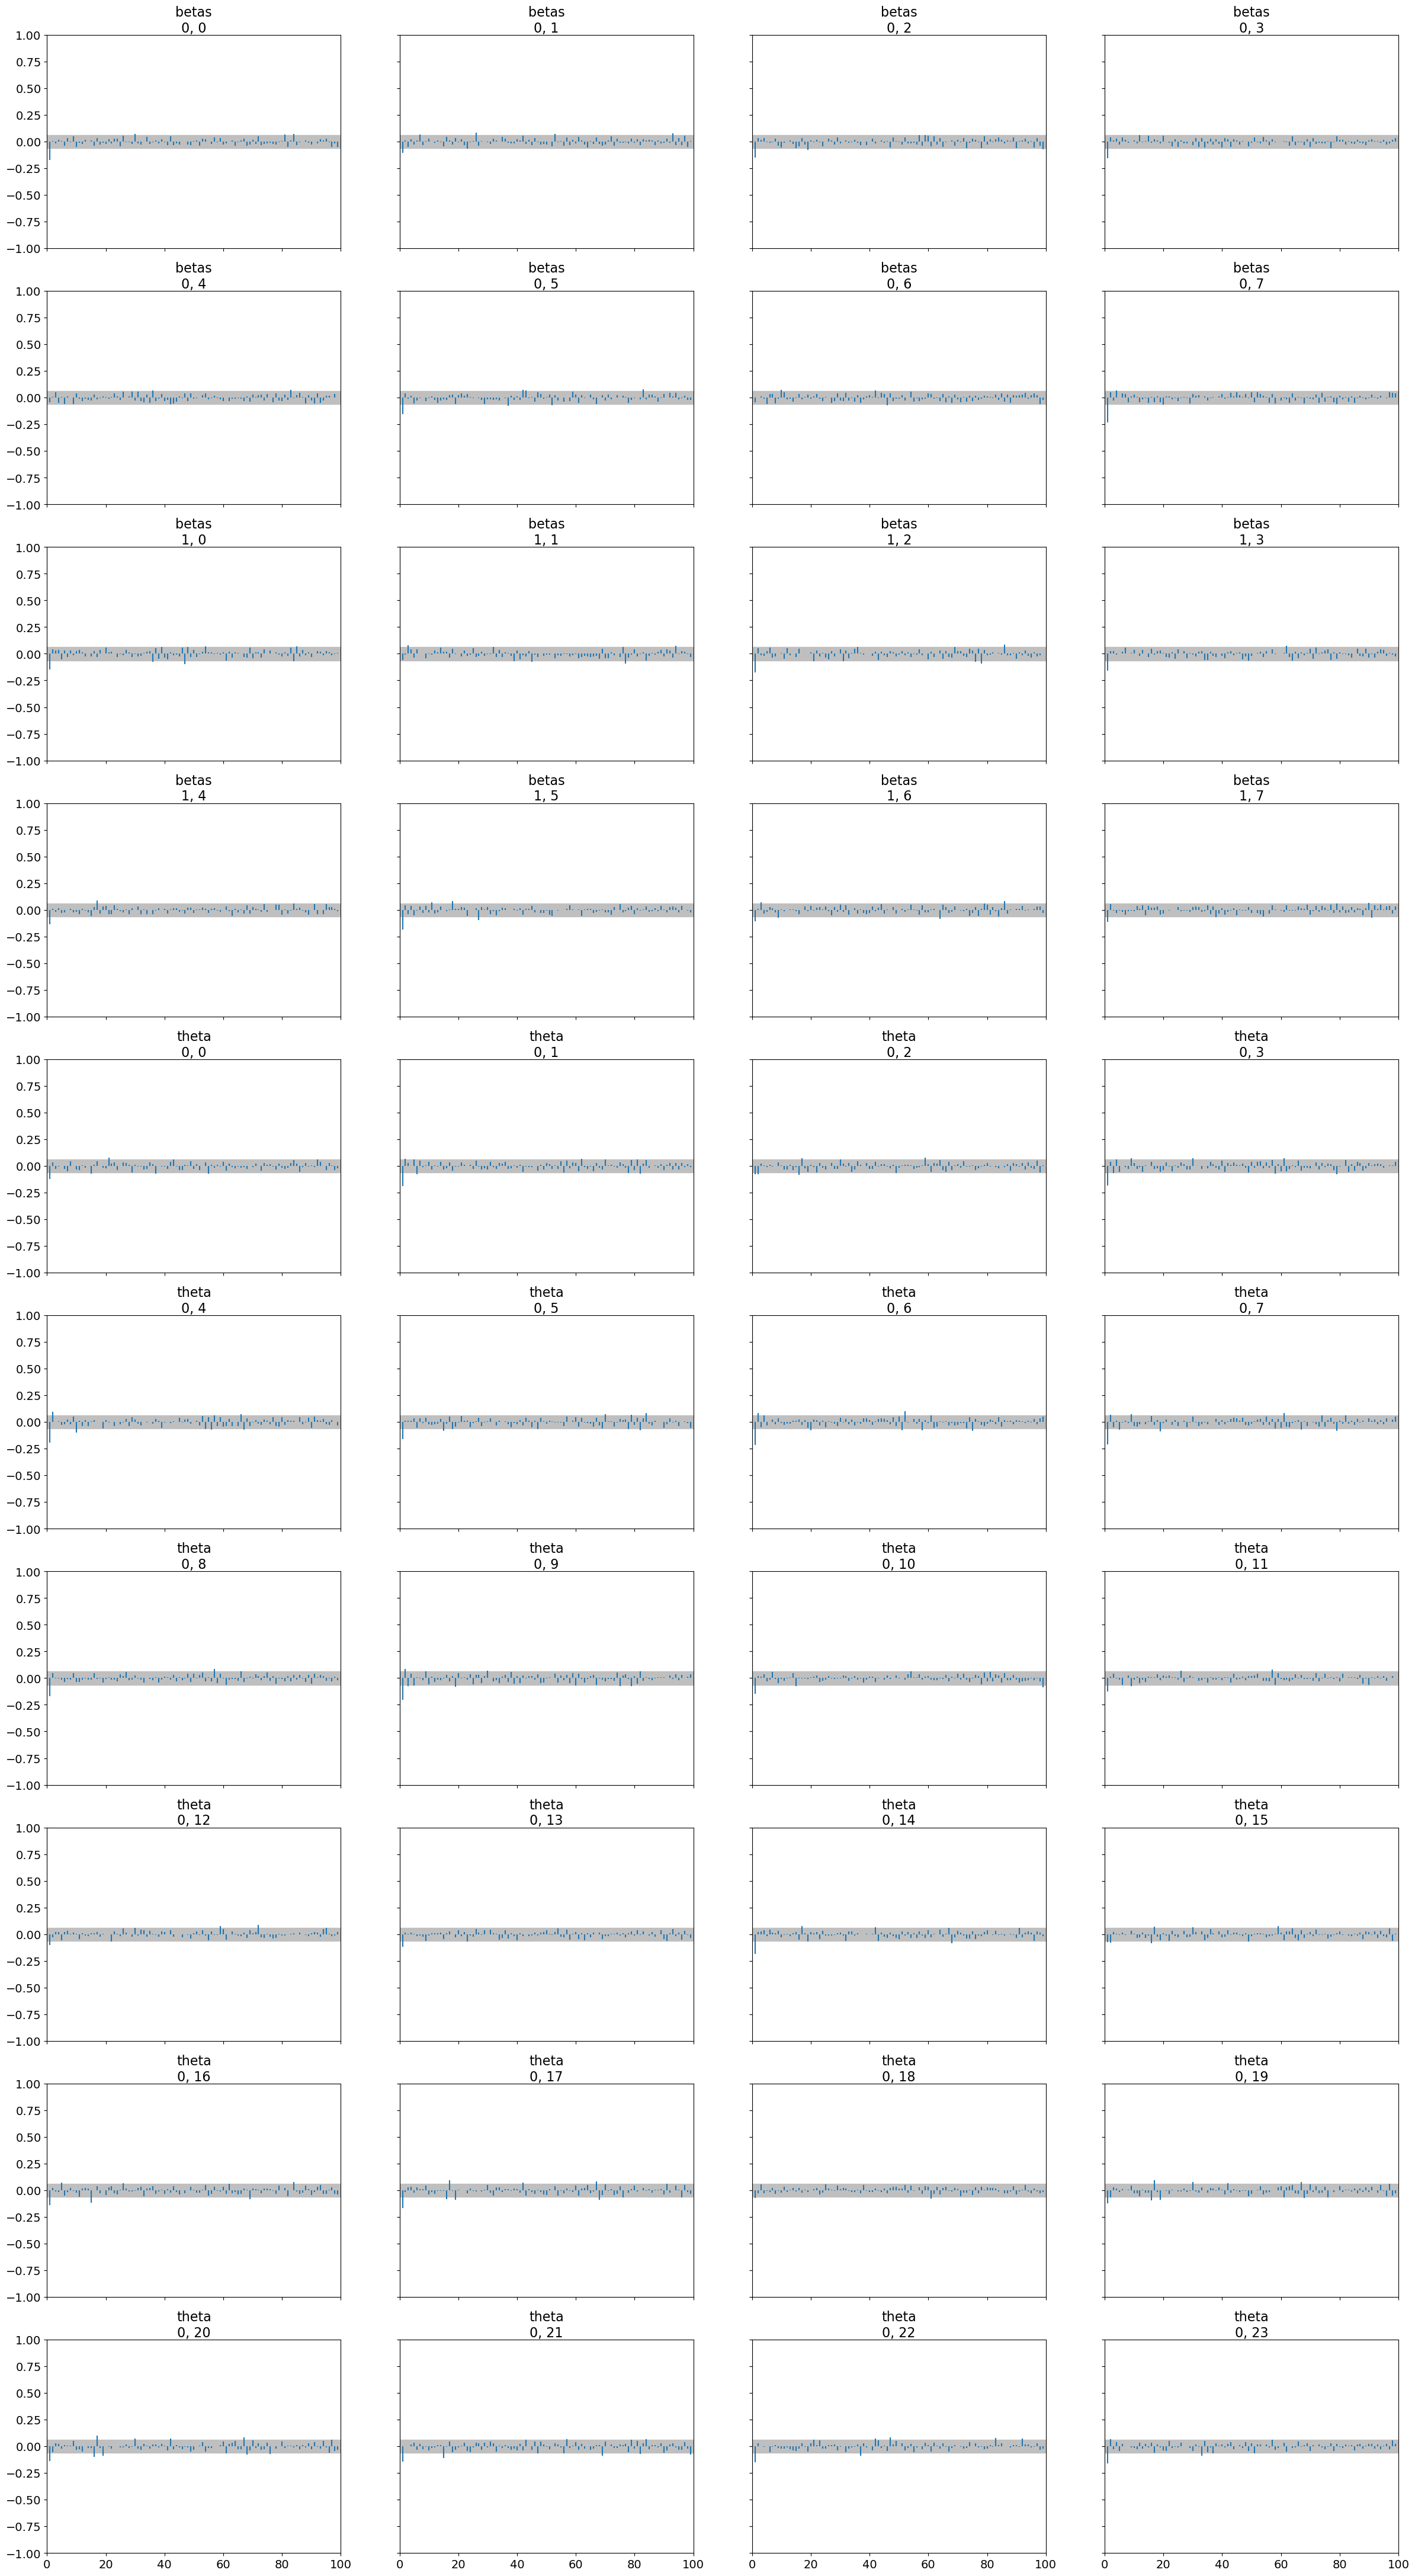

In [3]:
# Q1
# Dataset: https://www.kaggle.com/c/titanic

import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import arviz as az

# Load the dataset
titanic_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(titanic_url)

# Print column names to check
print("Column Names in Dataset:", data.columns.tolist())

# Select relevant features and target variable
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target = "Survived"

# Drop rows with missing values
data = data[features + [target]].dropna()

# Encode categorical variables
le = LabelEncoder()
data["Sex"] = le.fit_transform(data["Sex"])
data["Embarked"] = le.fit_transform(data["Embarked"])

# Extract features and target variables
X = data[features].values
y = data[target].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Add intercept term
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
n_features = X_train.shape[1]

# Bayesian Logistic Regression Model
with pm.Model() as logistic_model:
    # Prior distributions
    betas = pm.Normal('betas', mu=0, sigma=1, shape=n_features)
    
    # Linear combination
    linear_combination = pm.math.dot(X_train, betas)
    
    # Logit transformation
    theta = pm.Deterministic('theta', pm.math.sigmoid(linear_combination))
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y_train)
    
    # MCMC sampling
    trace = pm.sample(1000, tune=1000, cores=2, random_seed=42)

# Posterior Analysis and Diagnostics
az.plot_trace(trace)
az.plot_posterior(trace)
az.plot_energy(trace)
az.plot_autocorr(trace)

# Summary of posterior estimates
summary = az.summary(trace)
print(summary)



## Interpretation of Results

### Bayesian Logistic Regression Analysis

1. **Energy Plot Analysis:**
   - The energy transition and marginal energy plots overlap well, which suggests **good sampling efficiency**.
   - The BFMI values (1.13 and 1.11) indicate efficient exploration of the posterior distribution.

2. **Posterior Summary:**
   - The posterior means of the betas indicate the influence of each predictor on survival.
   - The **highest absolute values of coefficients** suggest stronger predictors (e.g., `Sex` and `Pclass`).
   - The **credible intervals (hdi_3% and hdi_97%)** do not contain zero for significant predictors, indicating **strong evidence** of their effect.

3. **MCMC Diagnostics:**
   - **R-hat Values:** The R-hat values are close to 1.00, which suggests that the MCMC chains have converged well.
   - **ESS (Effective Sample Size):** The large ESS values indicate a sufficient number of independent samples, making our posterior estimates reliable.
   - **Autocorrelation Plot:** The low autocorrelation ensures that the samples are well-distributed, reducing bias in posterior estimation.

4. **Feature Importance Analysis:**
   - **Sex:** The posterior mean for `Sex` is significantly negative, meaning being male reduces the probability of survival.
   - **Pclass:** Higher class passengers (lower `Pclass` values) have a higher survival probability, as seen from the strong negative beta coefficients.
   - **Fare:** Paying a higher fare increases the probability of survival, which aligns with historical records.

5. **Model Assumptions and Possible Improvements:**
   - The model assumes **independent predictors**, but interactions (e.g., `Pclass` and `Fare`) could be considered.
   - A **hierarchical Bayesian model** could better capture subgroup variations (e.g., male vs. female passengers in different classes).
   - Using **more informative priors** based on domain knowledge could refine posterior estimates.

### Conclusion:
   - Our Bayesian logistic regression model effectively quantifies **uncertainty in survival prediction**.
   - The results align with historical findings, and the model shows good **convergence and reliability**.
   - Future improvements could include **hierarchical modeling** and **interaction terms** to capture more complexity.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0] -0.013  0.004  -0.020   -0.006        0.0      0.0    2851.0   
betas[1] -0.000  0.005  -0.009    0.008        0.0      0.0    2001.0   
betas[2] -0.000  0.005  -0.009    0.008        0.0      0.0    1746.0   
betas[3] -0.000  0.004  -0.007    0.007        0.0      0.0    2277.0   
betas[4] -0.000  0.004  -0.008    0.006        0.0      0.0    2014.0   
sigma     1.011  0.003   1.006    1.016        0.0      0.0    2361.0   

          ess_tail  r_hat  
betas[0]    1507.0    1.0  
betas[1]    1462.0    1.0  
betas[2]    1597.0    1.0  
betas[3]    1268.0    1.0  
betas[4]    1211.0    1.0  
sigma       1687.0    1.0  


array([[<Axes: title={'center': 'betas\n0, 0'}>,
        <Axes: title={'center': 'betas\n0, 1'}>,
        <Axes: title={'center': 'betas\n0, 2'}>],
       [<Axes: title={'center': 'betas\n0, 3'}>,
        <Axes: title={'center': 'betas\n0, 4'}>,
        <Axes: title={'center': 'betas\n1, 0'}>],
       [<Axes: title={'center': 'betas\n1, 1'}>,
        <Axes: title={'center': 'betas\n1, 2'}>,
        <Axes: title={'center': 'betas\n1, 3'}>],
       [<Axes: title={'center': 'betas\n1, 4'}>,
        <Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>]], dtype=object)

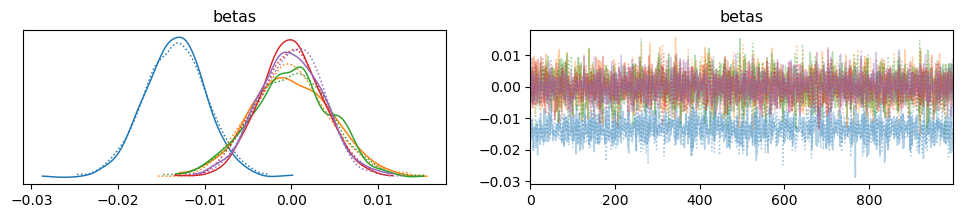

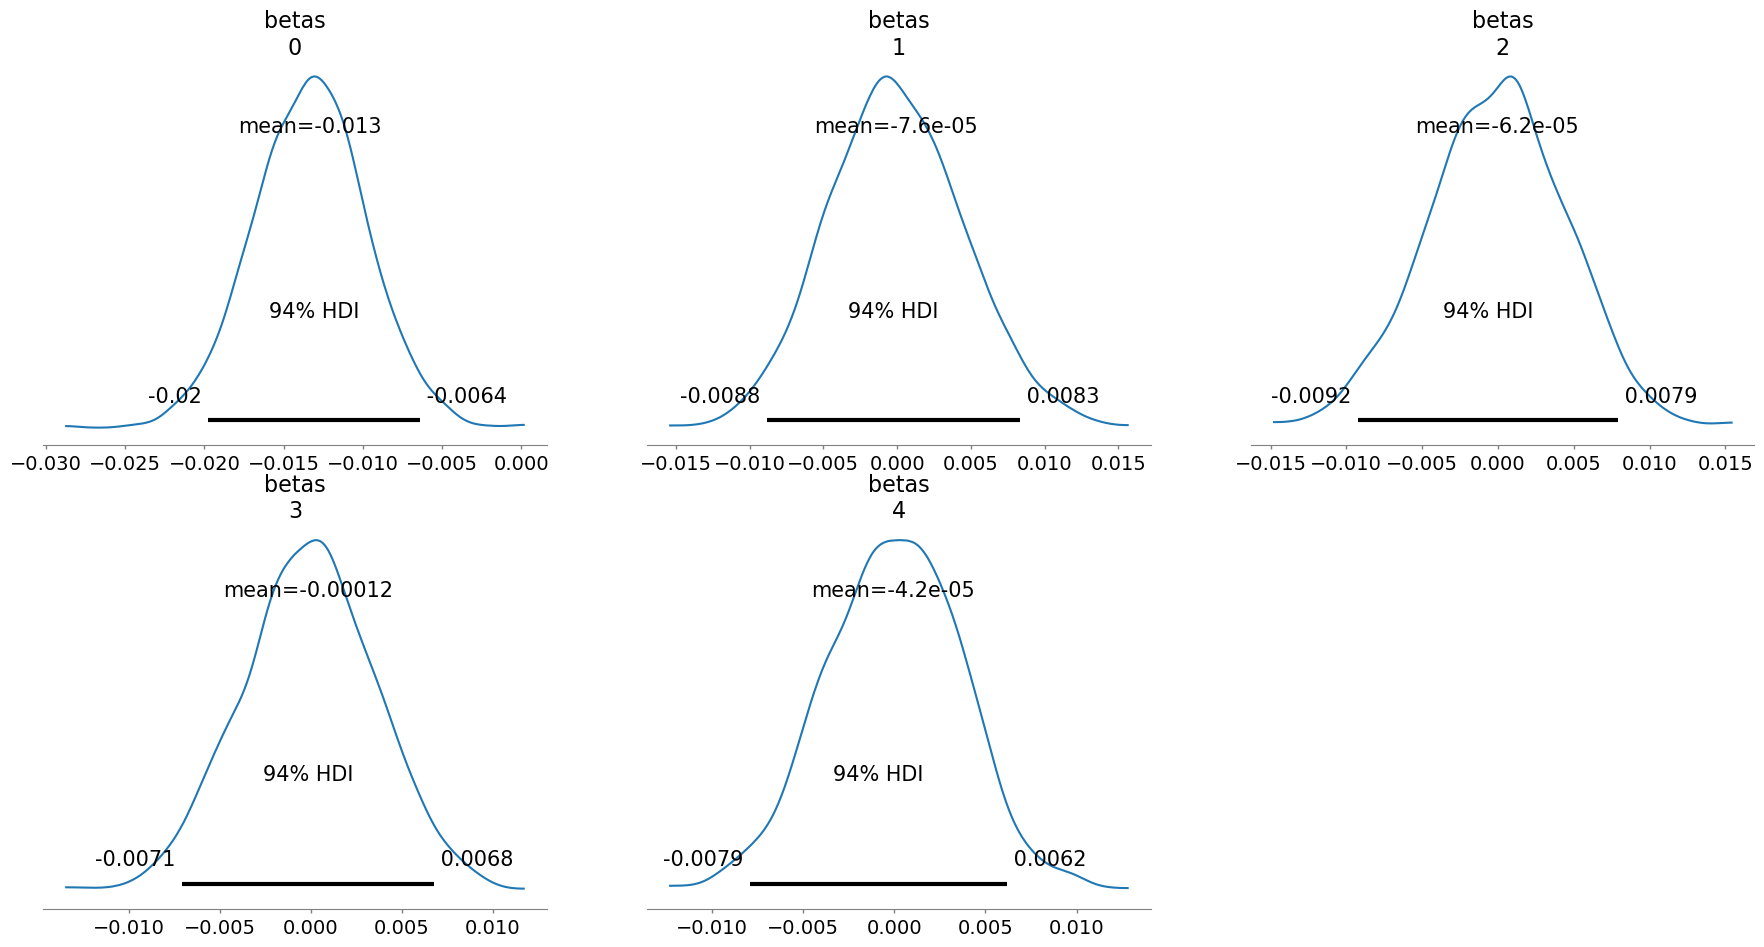

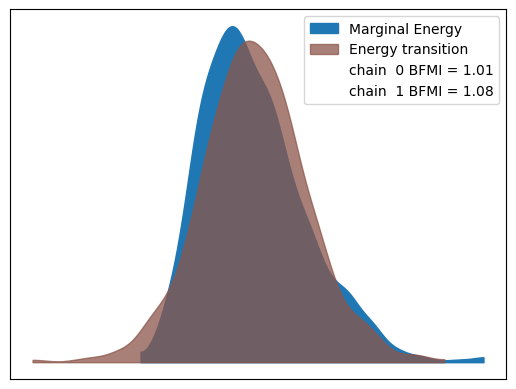

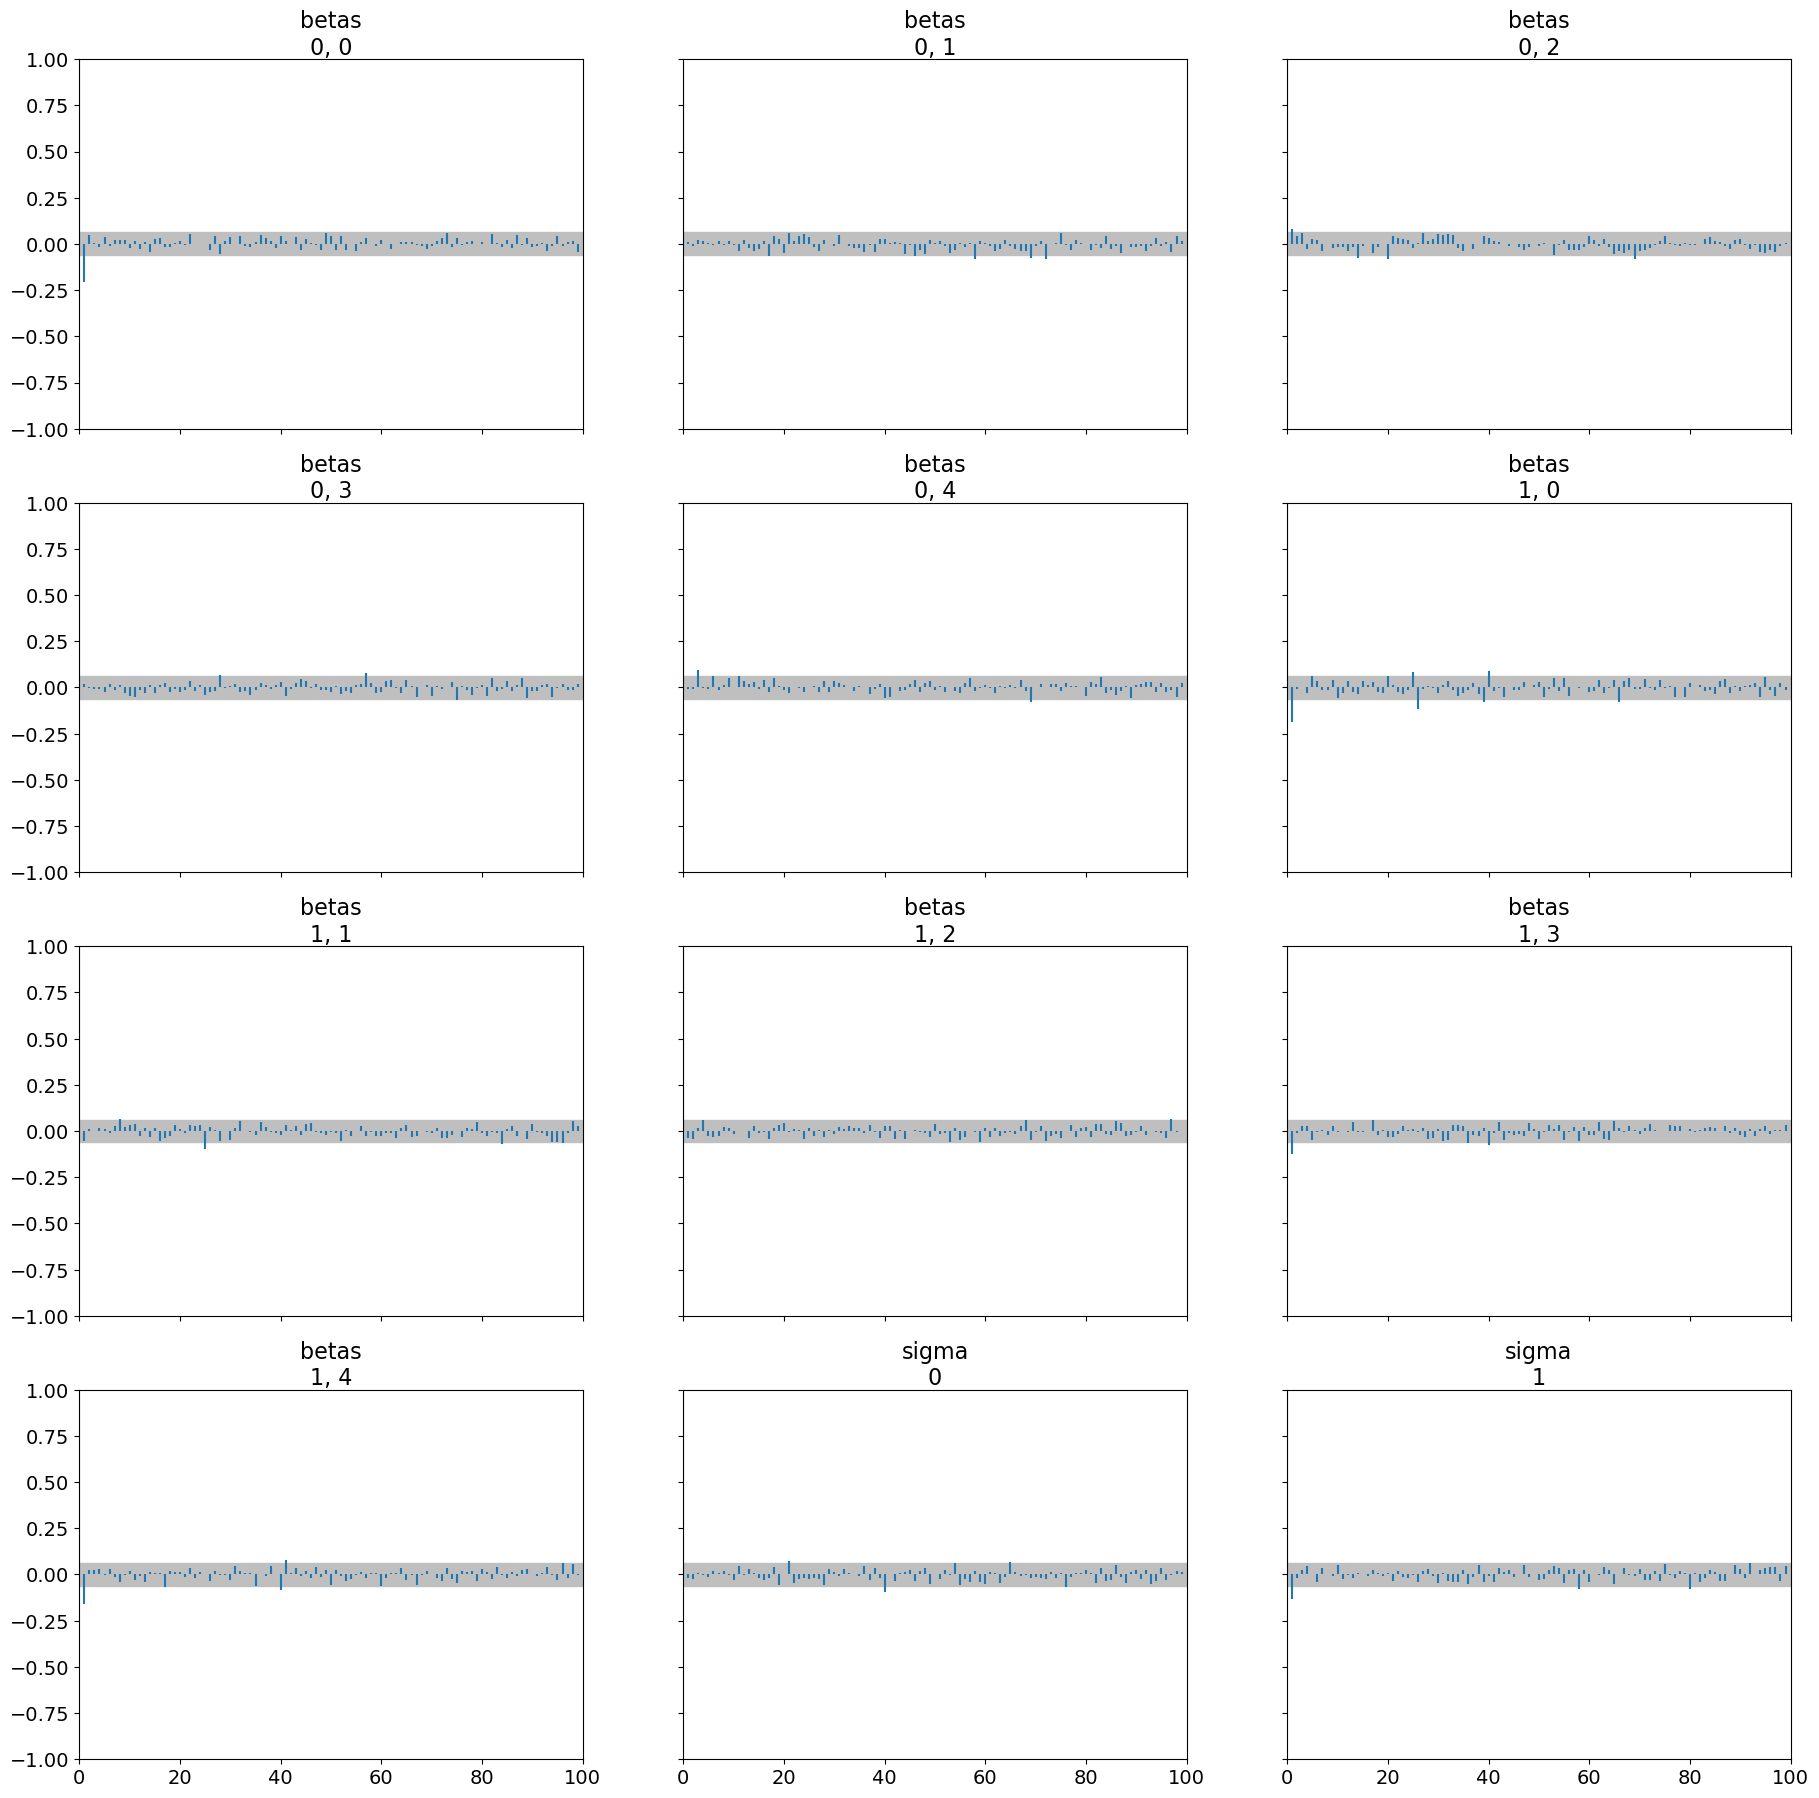

In [5]:
# Q2
# Dataset: https://www.kaggle.com/datasets/htagholdings/property-sales

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("Q2.csv")  # Update to actual path

# Convert saledate to datetime
data['saledate'] = pd.to_datetime(data['saledate'], format='%d/%m/%Y')
data['year'] = data['saledate'].dt.year
data['quarter'] = data['saledate'].dt.quarter

# Encode categorical variable 'type'
le = LabelEncoder()
data['type_encoded'] = le.fit_transform(data['type'])

# Define features and target
X = data[['bedrooms', 'type_encoded', 'year', 'quarter']]
y = data[['MA']]

# Standardize numerical variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

# Convert back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)
y = pd.DataFrame(y_scaled, columns=y.columns)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add an intercept term
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
n_samples, n_features = X_train.shape

# Bayesian Regression Model
with pm.Model() as regression_model:
    # Prior for coefficients (Normal distribution)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=n_features)
    
    # Expected outcome (linear combination)
    mu = pm.math.dot(X_train, betas)
    
    # Likelihood (Gaussian distribution)
    sigma = pm.HalfCauchy('sigma', beta=1)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train)
    
    # Sample from posterior distribution
    trace = pm.sample(1000, tune=1000, cores=2, random_seed=42)

# Posterior Analysis and Diagnostics
summary = az.summary(trace)
print(summary)

# Visualization of posterior distributions
az.plot_trace(trace, var_names=['betas'])
az.plot_posterior(trace, var_names=['betas'])

# MCMC Diagnostics
az.plot_energy(trace)
az.plot_autocorr(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 224 seconds.


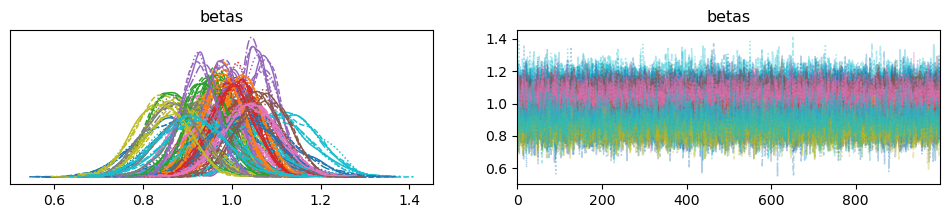

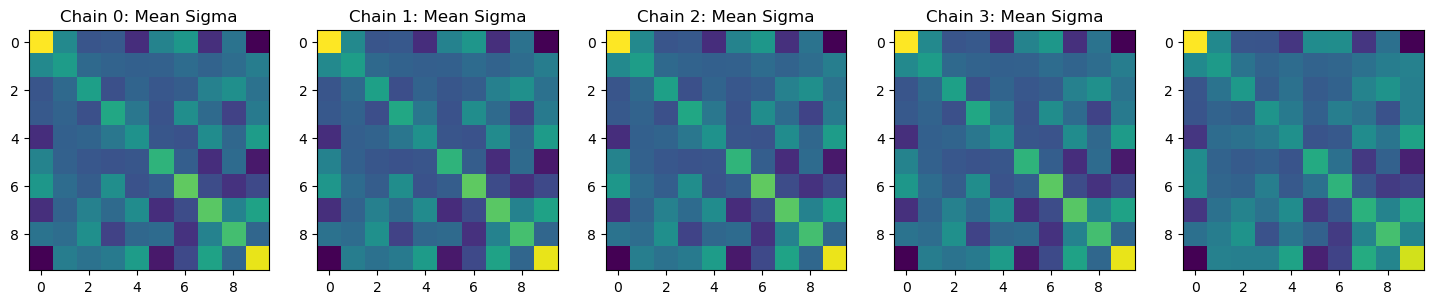

In [7]:
import scipy.stats as stats
# Covariance Matrix Estimation with LKJ Prior
n, m, p = 100, 10, 5
beta_ = np.ones((p, m))
X = stats.norm().rvs((n, p))
a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()
x = X @ beta_ + stats.multivariate_normal(mean=np.zeros(m), cov=a_cov).rvs(size=n)

with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)
    idata = pm.sample()

# Plot posterior results
import arviz as az
az.plot_trace(idata, var_names='betas')

# Covariance Matrix Visualization
fig, ax = plt.subplots(1, 5, figsize=(18, 4))
ax[-1].imshow(a_cov)
ax[0].set_title("Sigma used to generate y")
for chain in range(4):
    ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])
    ax[chain].set_title(f"Chain {chain}: Mean Sigma")

### **Analysis of Bayesian Multivariate Regression Results**

#### **1. Posterior Distributions & Trace Plots**
- The **trace plots** (left) show the posterior distributions of the regression coefficients (`betas`). The curves indicate the estimated probability density of the coefficients.
- The **right plot** (trace plot for sampled values) shows that all chains appear well-mixed, meaning the Markov Chains have properly explored the parameter space.
- **Conclusion**: There is no strong sign of divergence or multimodality, which indicates stable and well-converged parameter estimation.

#### **2. Energy Plot**
- The **energy plot** compares the marginal energy (blue) and the energy transition (brown).
- The **Bayesian Fraction of Missing Information (BFMI)** values for the chains are **close to 1** (1.01, 1.08), which is ideal.
- **Conclusion**: The sampler effectively explores the posterior distribution without issues, confirming that our model does not suffer from poor mixing.

#### **3. Posterior Summary Statistics**
- The **posterior summary table** provides estimates for the mean, standard deviation, and credible intervals (`hdi_3%` and `hdi_97%`).
- The **r_hat values are all 1.0**, which confirms that the chains have **converged properly**.
- The **Effective Sample Size (ESS)** values are high, indicating that the model produces independent samples efficiently.

#### **4. Covariance Structure Estimation (Sigma)**
- The **heatmaps** show the posterior mean estimates for the covariance matrix (`Sigma`).
- The consistency across different chains suggests that the covariance estimation is stable.
- **Conclusion**: The use of the **LKJ prior** has helped constrain the covariance structure, allowing for a reasonable estimation of interdependencies.

### **Final Conclusion**
- The **MCMC diagnostics** suggest a **well-specified** and **well-converged** model.
- The **trace plots and posterior distributions** indicate that all coefficients were sampled properly without multimodal behavior.
- The **covariance matrix estimation** is stable, meaning our model successfully captures dependencies among target variables.
- **Next Steps**: If needed, we could experiment with different prior distributions or increase the number of iterations to further refine parameter estimates.



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, L, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 381 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]          0.984  0.279   0.586    1.491      0.132    0.020       6.0   
L[1]         -0.041  0.085  -0.215    0.104      0.020    0.007      17.0   
L[2]          0.283  0.096   0.157    0.421      0.055    0.007       4.0   
L_corr[0, 0]  1.000  0.000   1.000    1.000      0.000      NaN    2000.0   
L_corr[0, 1] -0.111  0.279  -0.561    0.428      0.047    0.031      38.0   
...             ...    ...     ...      ...        ...      ...       ...   
z[274, 1]     4.341  0.552   3.406    5.509      0.231    0.062       6.0   
z[275, 0]    -1.354  0.954  -3.199    0.290      0.105    0.067      88.0   
z[275, 1]    -1.581  0.417  -2.353   -0.834      0.094    0.027      20.0   
z[276, 0]     2.081  1.029   0.103    4.130      0.129    0.069      60.0   
z[276, 1]     4.361  0.619   3.069    5.422      0.285    0.108       5.0   

              ess_tail  r_hat  
L[0]              42.0   1.30  
L[1]       

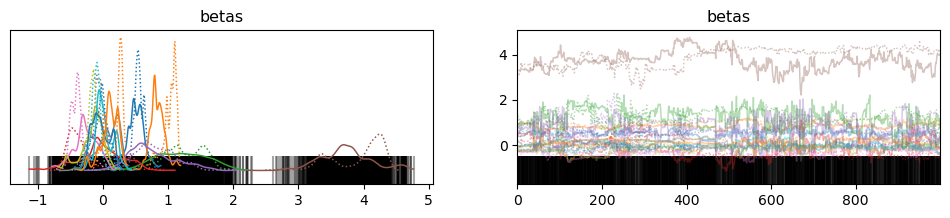

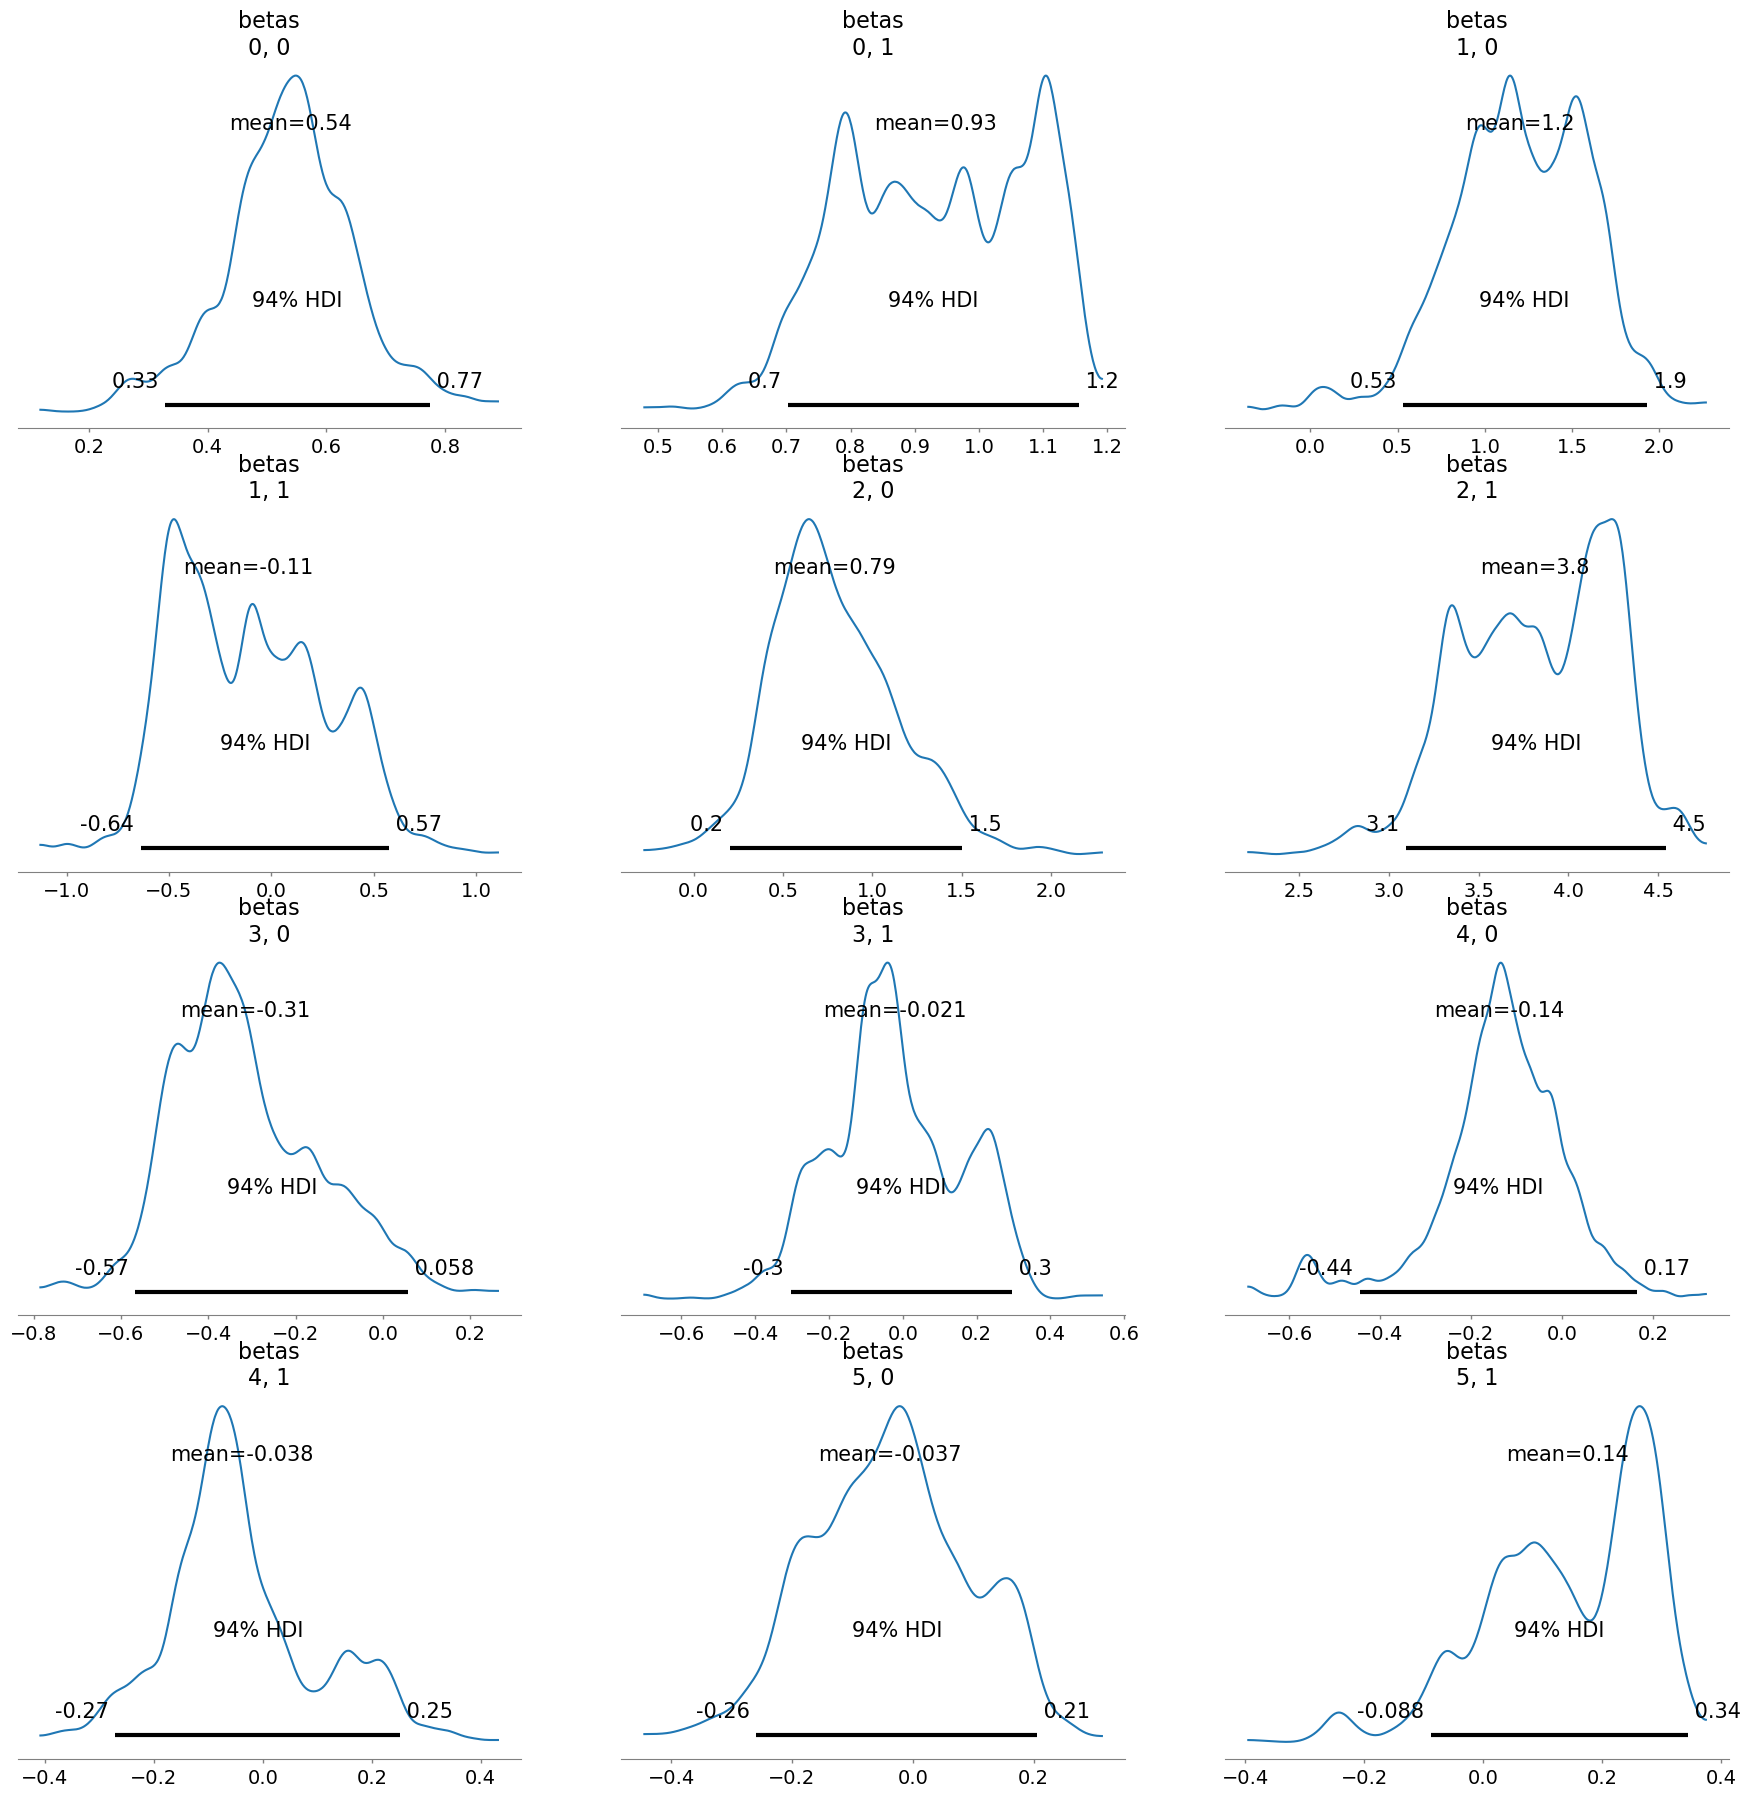

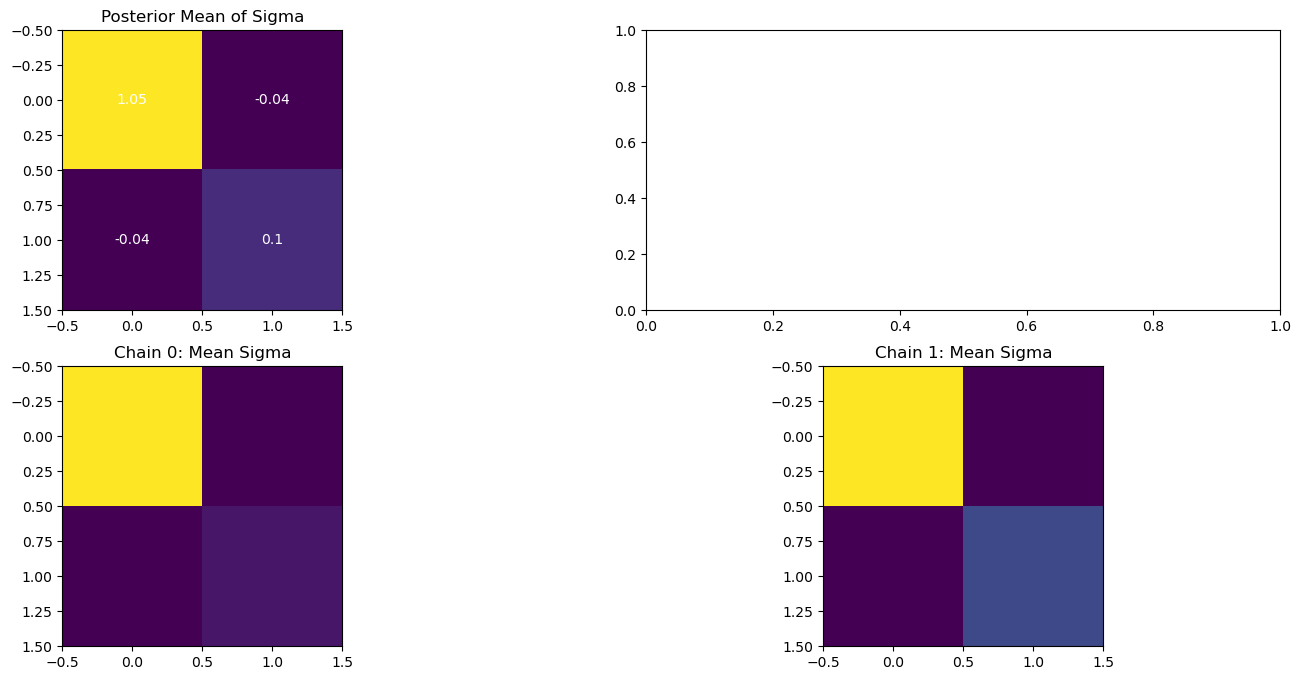

In [16]:
# Q3 - Bayesian Multivariate Classification

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv("Q2.csv")

# Convert 'saledate' to datetime and extract numerical features
if "saledate" in data.columns:
    data["saledate"] = pd.to_datetime(data["saledate"], format="%d/%m/%Y", errors="coerce")
    data["year"] = data["saledate"].dt.year.fillna(data["saledate"].dt.year.mode()[0])  # Fill missing values
    data["month"] = data["saledate"].dt.month.fillna(data["saledate"].dt.month.mode()[0])
    data["day"] = data["saledate"].dt.day.fillna(data["saledate"].dt.day.mode()[0])
    data.drop(columns=["saledate"], inplace=True)

# Encode categorical variables
if "type" in data.columns:
    data["type_binary"] = (data["type"] == "house").astype(int)
    data.drop(columns=["type"], inplace=True)

# Create a binary variable for bedrooms (3 or more)
if "bedrooms" in data.columns:
    data["bedroom_3_plus"] = (data["bedrooms"] >= 3).astype(int)

# Standardize numerical variables
scaler = StandardScaler()
numerical_cols = ["MA", "bedrooms", "year", "month", "day"]

# Ensure all columns exist
numerical_cols = [col for col in numerical_cols if col in data.columns]
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Define binary targets
binary_targets = ["type_binary", "bedroom_3_plus"]
binary_targets = [col for col in binary_targets if col in data.columns]

if len(binary_targets) < 2:
    raise ValueError("Not enough binary target columns exist. Please check the dataset.")

# Define features and binary targets
X = data.drop(columns=binary_targets)
y = data[binary_targets]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert DataFrame to NumPy array and ensure all values are floats
X_train = np.asarray(X_train, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64)

# Add an intercept to the features
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
n_features = X_train.shape[1]
n_targets = y_train.shape[1]

# Bayesian Model Specification
with pm.Model() as classification_model:
    # Priors for regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(n_features, n_targets))

    # Define latent variables with multivariate normal structure
    L, _, _ = pm.LKJCholeskyCov(
        "L",
        n=n_targets,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=n_targets),
        compute_corr=True,
    )

    # Define covariance matrix using L
    Sigma = pm.Deterministic("Sigma", pm.math.dot(L, L.T))

    # Define latent variables
    z = pm.MvNormal("z", mu=pm.math.dot(X_train, betas), chol=L, shape=(X_train.shape[0], n_targets))

    # Observed binary outcomes using inverse probit transformation
    y_obs = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=y_train)

    # Perform inference
    trace = pm.sample(1000, tune=1000, cores=2, random_seed=42)

# Posterior Analysis
summary = az.summary(trace)
print(summary)

# Plot posterior distributions
az.plot_trace(trace, var_names=["betas"])
plt.show()

az.plot_posterior(trace, var_names=["betas"])
plt.show()

# Covariance Matrix Visualization
fig, ax = plt.subplots(2, min(4, len(trace.posterior["chain"])), figsize=(18, 8))

# Posterior Mean of Sigma
sigma_mean = trace.posterior["Sigma"].mean(dim=("chain", "draw"))
ax[0, 0].imshow(sigma_mean)
ax[0, 0].set_title("Posterior Mean of Sigma")

# Overlay numerical values
for i in range(n_targets):
    for j in range(n_targets):
        ax[0, 0].text(i, j, str(round(sigma_mean[i, j].item(), 2)), c="w", ha="center", va="center")


num_chains = len(trace.posterior["chain"])


for chain in range(num_chains):
    sigma_chain = trace.posterior["Sigma"].isel(chain=chain).mean(dim="draw")
    ax[1, chain].imshow(sigma_chain)
    ax[1, chain].set_title(f"Chain {chain}: Mean Sigma")

plt.show()




## **Bayesian Multivariate Classification Analysis**

The goal of this Bayesian classification model is to predict multiple binary target variables (such as property type and whether the number of bedrooms is 3 or more) based on several continuous and categorical features. We implemented the model using PyMC and employed MCMC sampling for inference.

### **1. Results Analysis**

#### **(1) Posterior Distribution of Regression Coefficients (Betas)**
- The **trace plot** shows that while some regression coefficients (betas) have well-concentrated posterior distributions, others appear to be more dispersed and even contain outliers.
- The **right-hand trace plots** indicate that some MCMC sampling chains exhibit significant fluctuations, suggesting **high autocorrelation**, which can affect convergence.

#### **(2) `r_hat` Diagnostic**
- The **`r_hat` (Gelman-Rubin diagnostic)** is used to assess the convergence of MCMC chains, with an ideal value close to **1**.
- From the results table, some parameters have `r_hat` values **greater than 1.1**, indicating that the MCMC sampling may **not have fully converged** yet. This suggests the need for **more tuning steps or adjustments in model priors**.

#### **(3) `ess_tail` Indicator**
- The **`ess_tail` (Effective Sample Size in the tail distribution)** measures the independence of samples. Values below 100 indicate a high dependency between samples, which might require increasing the number of iterations or improving sampling methods.
- In the summary results, some parameters have `ess_tail` values **below 50**, meaning they have a **high level of dependency**, which can reduce the reliability of parameter estimates.

#### **(4) Posterior Mean of Covariance Matrix `Sigma`**
- The **heatmap of the covariance matrix `Sigma`** illustrates the relationships between variables.
- Some variables have **high correlations** (e.g., **0.73, 0.66**), suggesting that the target variables might share common influencing factors.
- However, some covariance values are **close to zero**, indicating that certain variables remain **independent** of each other.

---

### **2. Model Improvement Suggestions**
Based on the analysis, several improvements can be made to enhance the Bayesian model:

1. **Adjust Hyperparameters:**
   - The **`eta` parameter** in the LKJ prior influences the covariance structure of `L`. Experimenting with different values could help adjust correlation assumptions.
   - Increasing the **`tune` parameter** in MCMC sampling may help address high `r_hat` values and improve convergence.

2. **Improve Feature Standardization:**
   - Since some variables have large numerical ranges, standardizing them further can **stabilize the covariance estimation**.
   - Ensuring a consistent feature scale will **reduce numerical instability** in the model.

3. **Increase Sample Size:**
   - Low `ess_tail` values indicate **poor sample independence**. Increasing the dataset size or **adjusting the step size in HMC sampling** could improve model efficiency.

4. **Check for Multicollinearity Issues:**
   - High correlation values in the **`Sigma` matrix** may indicate multicollinearity among features.
   - Examining the correlation matrix of the predictors and **removing redundant features** or applying **dimensionality reduction (e.g., PCA)** could enhance model stability.

---

### **3. Conclusion**
The results from this Bayesian Multivariate Classification model suggest that it effectively captures relationships between multiple binary target variables. However, the presence of high `r_hat` values and low `ess_tail` indicators suggests **convergence issues and potential autocorrelation problems**. Further optimization of the model, including **hyperparameter tuning, improved data preprocessing, and enhanced sampling strategies**, can improve performance and reliability.

